In [1]:
!pip install anndata pandas seaborn matplotlib

In [2]:
import anndata
import pandas as pd

In [3]:
def h5ad_obs_to_csv(input_h5ad):
    output_csv = input_h5ad.replace('.h5ad', '.obs.csv')
    x = anndata.read_h5ad(input_h5ad, backed='r')
    x.obs.to_csv(output_csv)


In [4]:
datasets = {
  'KPMP SC RNAseq': 'kpmp-sc-rnaseq.h5ad',
  'KPMP SN RNAseq': 'kpmp-sn-rnaseq.h5ad',
  'HuBMAP Left Kidney': 'hubmap-LK-processed.h5ad',
  'HuBMAP Right Kidney': 'hubmap-RK-processed.h5ad'
}

In [5]:
for h5ad in datasets.values():
    h5ad_obs_to_csv(h5ad)

In [6]:
!head -3 *.csv

==> all-normalized-obs.csv <==
consortium,collection,dataset_id,cell_id,as_id,cl_id,cl_label,gene_count,age,sex,race,disease
KPMP,KPMP SC RNAseq,5655_EO-2,S2008000605HRT_AAACCCAGTGCACATT-1,UBERON:0002113,CL:1001431,kidney collecting duct principal cell,10505.0,50-59,Male,European,normal
KPMP,KPMP SC RNAseq,5655_EO-2,S2008000605HRT_AAACCCAGTGCCTACG-1,UBERON:0002113,CL:1001431,kidney collecting duct principal cell,9698.0,50-59,Male,European,normal

==> hubmap-LK-processed.obs.csv <==
cell_id,uuid,hubmap_id,age,sex,height,weight,bmi,cause_of_death,race,barcode,dataset,azimuth_label,azimuth_id,predicted_CLID,predicted_label,cl_match_type,prediction_score,n_genes,n_counts,leiden
853ab5348f619043ab2f997ac8ae14f0-AAACCCACAAGGTCTT,853ab5348f619043ab2f997ac8ae14f0,HBM344.QRJX.878,25.0,Female,160.0,86.0,33.5,Anoxia,White,AAACCCACAAGGTCTT,853ab5348f619043ab2f997ac8ae14f0,Inner Medullary Collecting Duct,AZ:0000043,CL:1000718,kidney inner medulla collecting duct principal cell,skos:exactMatch,0.496

In [7]:
def normalize_category(str):
    str = str.strip()
    if str == "" or str == "unknown":
        return "Unknown"
    else:
        return str

def normalized_age(age):
    match age.split(" ")[0]:
        case "first":
            age = 0
        case "second":
            age = 10
        case "third":
            age = 20
        case "fourth":
            age = 30
        case "fifth":
            age = 40
        case "sixth":
            age = 50
        case "seventh":
            age = 60
        case "eighth":
            age = 70
        case "nineth":
            age = 80
        case "tenth":
            age = 90
    age = str(age)
    if age != "" and age[0].isdigit():
        return f"{age[0]}0-{age[0]}9"
    else:
        return normalize_category(age)

def normalize_race(race):
    if race == "African American":
        return "Black or African American"
    else:
        return normalize_category(race)

def normalize_hubmap_row(row, collection):
    normalized_row = {
        "consortium": "HuBMAP",
        "collection": collection,
        "dataset_id": row["uuid"],
        "cell_id": row["cell_id"],
        "as_id": "UBERON:0002113",
        "cl_id": row["predicted_CLID"],
        "cl_label": row["predicted_label"],
        "gene_count": row["n_genes"],
        "age": normalized_age(row["age"]),
        "sex": normalize_category(row["sex"].title()),
        "race": normalize_race(row["race"]),
        "disease": "normal"
    }
    return normalized_row

def normalize_kpmp_row(row, collection):
    normalized_row = {
        "consortium": "KPMP",
        "collection": collection,
        "dataset_id": row.get("LibraryID", row.get("library_id", "Unknown")),
        "cell_id": row[""],
        "as_id": row["tissue_ontology_term_id"],
        "cl_id": row["cell_type_ontology_term_id"],
        "cl_label": row["cell_type"],
        "gene_count": row["nCount_RNA"],
        "age": normalized_age(row["Age_binned"]),
        "sex": normalize_category(row["sex"].title()),
        "race": normalize_race(row["self_reported_ethnicity"]),
        "disease": normalize_category(row["disease"])
    }
    return normalized_row

fields = ["consortium", "collection", "dataset_id", "cell_id", "as_id", "cl_id", "cl_label", "gene_count", "age", "sex", "race", "disease"]

In [8]:
import csv
with open("all-normalized-obs.csv", 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields)
    writer.writeheader()
    for (collection, h5ad) in datasets.items():
        obs_csv = h5ad.replace(".h5ad", ".obs.csv")
        with open(obs_csv, newline='') as obs_csvfile:
            reader = csv.DictReader(obs_csvfile)
            for row in reader:
                if h5ad.startswith("hubmap-"):
                    normalized_row = normalize_hubmap_row(row, collection)
                else:
                    normalized_row = normalize_kpmp_row(row, collection)
                writer.writerow(normalized_row)


In [9]:
!head -3 all-normalized-obs.csv

consortium,collection,dataset_id,cell_id,as_id,cl_id,cl_label,gene_count,age,sex,race,disease
KPMP,KPMP SC RNAseq,5655_EO-2,S2008000605HRT_AAACCCAGTGCACATT-1,UBERON:0002113,CL:1001431,kidney collecting duct principal cell,10505.0,50-59,Male,European,normal
KPMP,KPMP SC RNAseq,5655_EO-2,S2008000605HRT_AAACCCAGTGCCTACG-1,UBERON:0002113,CL:1001431,kidney collecting duct principal cell,9698.0,50-59,Male,European,normal


In [10]:
df = pd.read_csv("all-normalized-obs.csv")

# Create a dictionary to store unique values for each column
unique_values = {column: df[column].unique() for column in df.columns}

# Print unique values for each column
for column, values in unique_values.items():
    if len(values) < 100:
        print(f"\"{column}\" values ({len(values)}): {', '.join(values)}")
    else:
        print(f"\"{column}\" values ({len(values)}): {', '.join(map(str, values))[:200]}...")

"consortium" values (2): KPMP, HuBMAP
"collection" values (4): KPMP SC RNAseq, KPMP SN RNAseq, HuBMAP Left Kidney, HuBMAP Right Kidney
"dataset_id" values (379): 5655_EO-2, 5655_EO-3, 5655_EO-4, 5655_EO-5, 6034-EO-2, 6034-EO-3, 6034-EO-4, 6034-EO-5, 1117-EO-1, 1119-EO-1, 613-EO-2, 622-EO-2, 1119-EO-2, 1120-EO-1, 593-EO-1, 763-EO-4, 1120-EO-2, 573-EO-2, 2318-EO...
"cell_id" values (2304020): S2008000605HRT_AAACCCAGTGCACATT-1, S2008000605HRT_AAACCCAGTGCCTACG-1, S2008000605HRT_AAAGAACGTAGAGACC-1, S2008000605HRT_AAAGAACGTCGGAACA-1, S2008000605HRT_AAAGAACGTTAACAGA-1, S2008000605HRT_AAAGGATAGT...
"as_id" values (4): UBERON:0002113, UBERON:0001225, UBERON:0001228, UBERON:0000362
"cl_id" values (63): CL:1001431, CL:1000500, CL:1001111, CL:0000115, CL:0002306, CL:1001106, CL:1001107, CL:1001432, CL:0000910, CL:0000875, CL:0000990, CL:0000084, CL:1000695, CL:0000814, CL:0000786, CL:0000113, CL:0000576, CL:0000236, CL:0000623, CL:0001058, CL:0000097, CL:1000849, CL:0000653, CL:1000452, CL:1000768

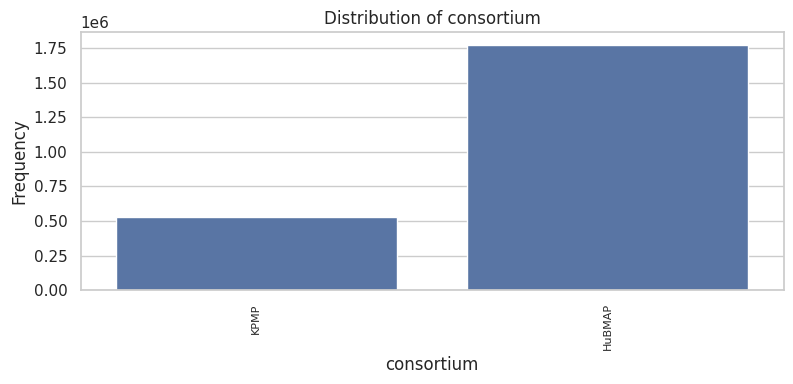

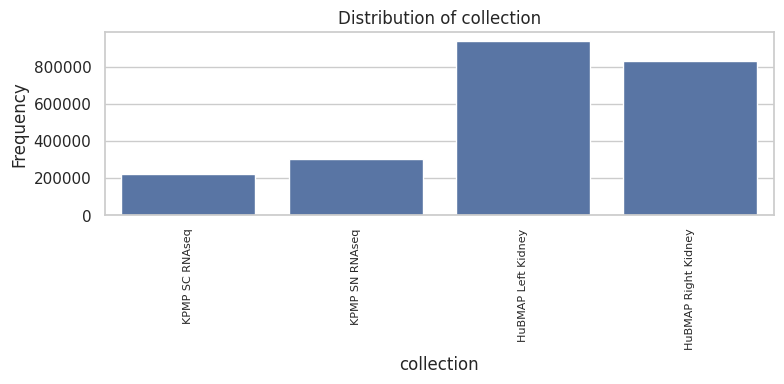

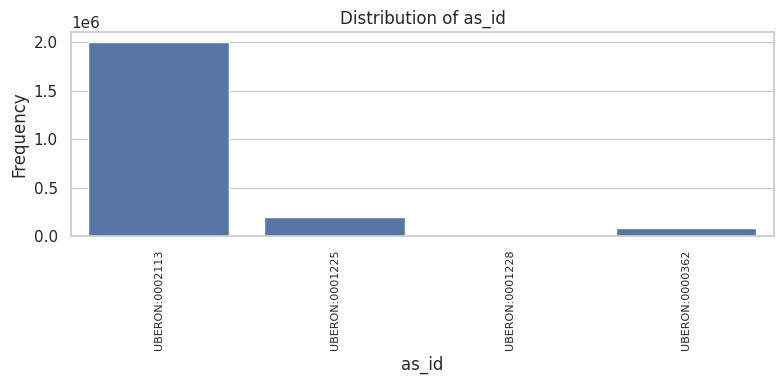

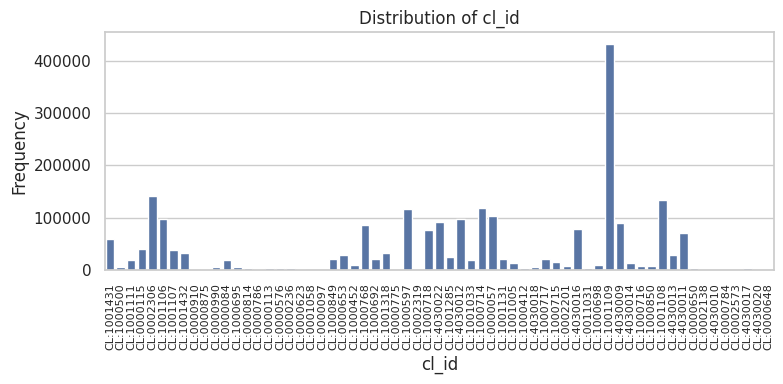

/tmp/ipykernel_31219/573429497.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


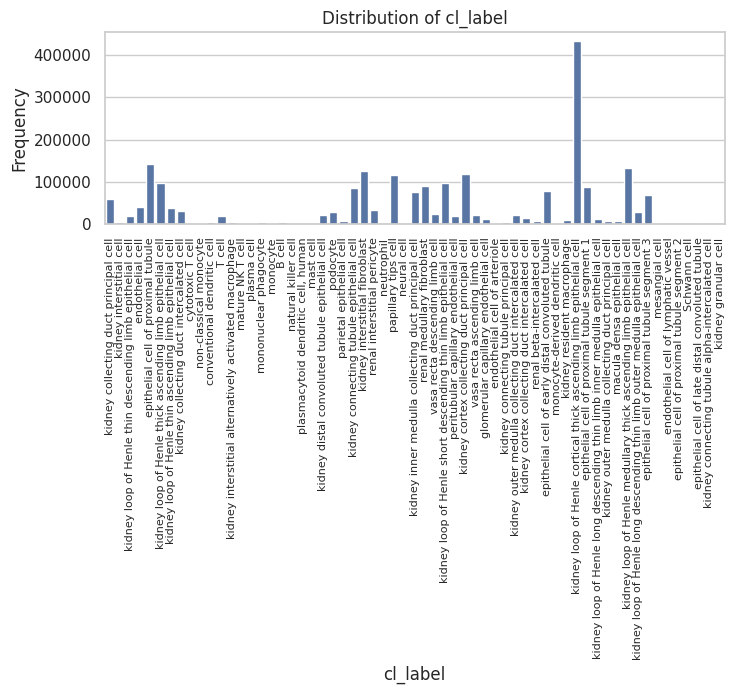

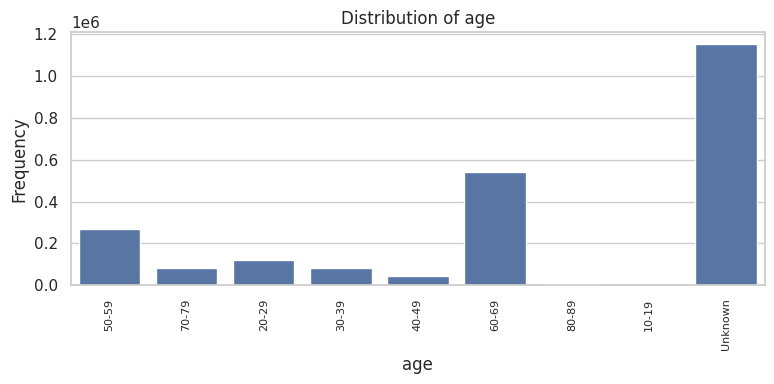

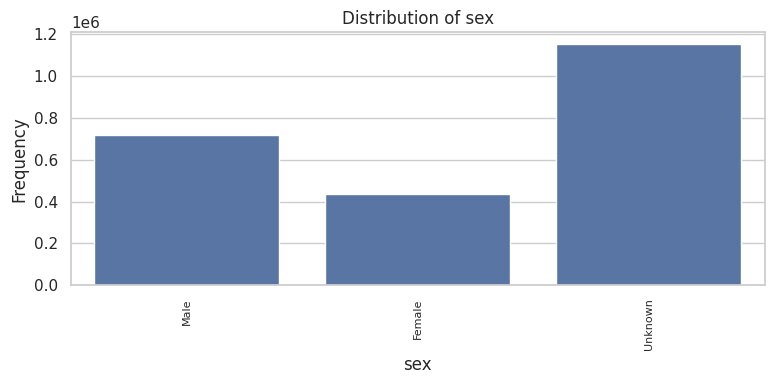

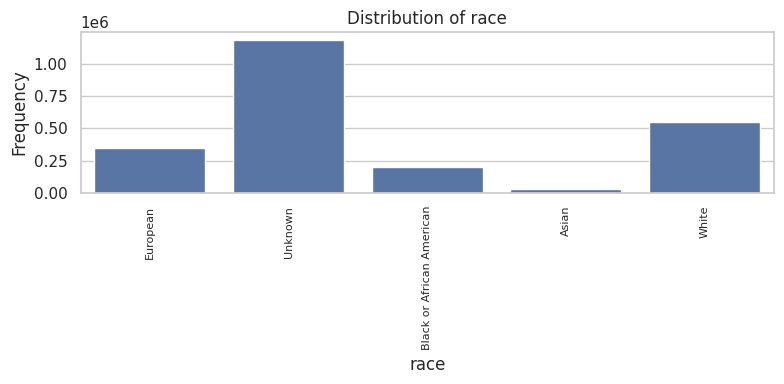

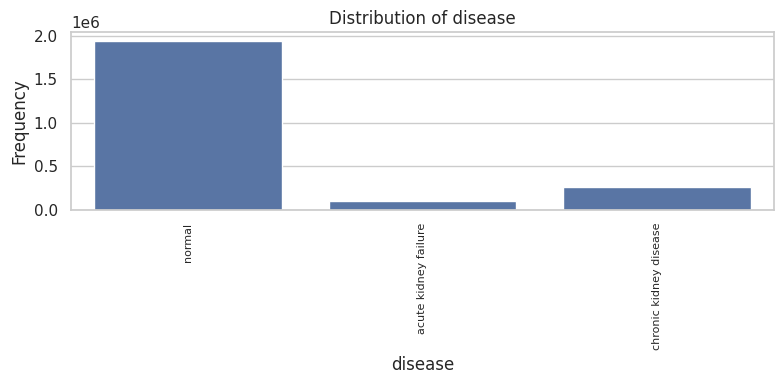

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

def plot_distribution(x, column):
    plt.figure(figsize=(8, 4))
    plt.xticks(rotation=90, fontsize=8)
    sns.countplot(x=column, data=x, stat='count')
    plt.title(f'Distribution of {column}')
    plt.gcf().subplots_adjust(bottom=0.4)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot the distribution of each column
for column in df.columns:
    if len(unique_values[column]) < 100:
        plot_distribution(df, column)
